### Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
import sys
sys.path.insert(0, '../scripts')
from utils import load_data, add_significance_bracket, get_all_interactions, get_interaction_length
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

### Read the data

In [3]:
fp = "../data/DANTE_Pilot_October 13, 2025_21.48.csv"
df = pd.read_csv(fp)
df = df.drop(index=[0,1])

get_all_interactions(df)

# remove internal test cases
df = df[df['participantId'] != ""]

# remove unfinished cases
df = df[df['Finished']=="True"]

# remove cases with no summary
df = df.dropna(subset=['summary', 'llm_response_1'])

# remove certain participants (HTTP and DOM errors with erroneous interactions)
error = ["6B5DC61D3F1A4FD59884E09A7390D115", "9C157F56FEEC4F22BAFEEC11763B9759", "F6586134F687435A9064E1C721EBC99F", "AF09ECC56B13406EAA4D174850B78291", "F28F21C7F66946B785FCCA3E4AEB26B2"]
duplicate_ip = ['3E8D695768544BFAAB256B25B286BE36', '2C25201441924CD69CFB850F9E0C25B7', 'ADE33812DFEE4679855302BB37ABFF84']
dnf = ['498B2C7CFDC6421A8DE46C96D56EFBB2', '57A3377A53CD49C3A03640AC86E08698', '6AEA21E0CC19480D95EF78972E41A441']
df = df[df['participantId'].apply(lambda x: x not in error+duplicate_ip+dnf)]

# Convo satisfaction to numeric
str_to_num = {"Strongly disagree": 1, "Somewhat disagree": 2, "Neither agree nor disagree": 3, "Somewhat agree": 4, "Strongly agree": 5}

for col in ['satis1', 'satis2']:
    df[col] = df[col].map(str_to_num)

# Treatment labels to more readable format
df['treatment'] = df['treatment'].apply(lambda x: f"{x.split('_')[0].capitalize()} {x.split('_')[1].capitalize()}")

# Average satisfaction
df['satis_avg'] = (df['satis1'] + df['satis2']) / 2

# Agree vs Disagree
df['agree_disagree'] = "Agree"
df.loc[df['treatment'].apply(lambda x: "Disagree" in x), 'agree_disagree'] = "Disagree"

# Ingroup vs Outgroup
df['ingroup_outgroup'] = "Ingroup"
df.loc[df['treatment'].apply(lambda x: "Outgroup" in x), 'ingroup_outgroup'] = "Outgroup"

### Get the conversation data in columns

In [7]:
from openai import OpenAI
client = OpenAI()

response = client.moderations.create(
    model="omni-moderation-latest",
    input="...text to classify goes here...",
)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [6]:
df

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,user_response_length_1,llm_response_length_1,user_response_length_2,llm_response_length_2,user_response_length_3,llm_response_length_3,user_response_length_4,llm_response_length_4,user_response_length_5,llm_response_length_5
2,2025-09-17 10:07:34,2025-09-17 10:12:03,IP Address,98.122.207.40,100,269,True,2025-09-17 10:12:03,R_7oCsprcktCBtsVG,NaN,...,NaN,133.0,42.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-09-17 10:08:34,2025-09-17 10:12:53,IP Address,68.81.204.147,100,258,True,2025-09-17 10:12:53,R_5y2Qdrp064Ag88S,NaN,...,NaN,135.0,16.0,126.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-09-17 10:08:02,2025-09-17 10:14:27,IP Address,64.226.154.114,100,384,True,2025-09-17 10:14:27,R_5czsPmFlqnSZ2iP,NaN,...,NaN,100.0,17.0,96.0,42.0,112.0,13.0,84.0,NaN,NaN
5,2025-09-17 10:07:50,2025-09-17 10:15:35,IP Address,24.254.250.19,100,464,True,2025-09-17 10:15:35,R_7H8KDxgopCfxgsx,NaN,...,NaN,103.0,19.0,88.0,40.0,122.0,NaN,NaN,NaN,NaN
6,2025-09-17 10:08:07,2025-09-17 10:15:45,IP Address,166.198.28.65,100,458,True,2025-09-17 10:15:45,R_5R7x26yCIF45oYu,NaN,...,NaN,88.0,45.0,110.0,26.0,103.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,2025-10-11 07:26:46,2025-10-11 07:35:26,IP Address,173.67.31.173,100,519,True,2025-10-11 07:35:27,R_360f2Z17lb4AC1X,NaN,...,NaN,74.0,35.0,67.0,12.0,110.0,5.0,29.0,NaN,NaN
2078,2025-10-11 07:16:30,2025-10-11 07:35:40,IP Address,172.59.112.38,100,1149,True,2025-10-11 07:35:40,R_1o5c6bdqEvNWC2D,NaN,...,NaN,112.0,20.0,111.0,37.0,115.0,NaN,NaN,NaN,NaN
2079,2025-10-11 07:10:24,2025-10-11 07:37:16,IP Address,68.235.139.47,100,1612,True,2025-10-11 07:37:17,R_79cvcoCuFggB2zO,NaN,...,NaN,141.0,83.0,146.0,61.0,163.0,88.0,92.0,NaN,NaN
2080,2025-10-11 07:28:47,2025-10-11 07:45:17,IP Address,24.188.27.245,100,989,True,2025-10-11 07:45:18,R_7VIIRy9o89QKiUH,NaN,...,NaN,86.0,7.0,91.0,14.0,89.0,2.0,29.0,NaN,NaN


In [5]:
for i in range(1, 6):
    for counterpart in ['user', 'llm']:
        col = f'{counterpart}_response_{i}'
        df.loc[~df[col].isna(), f"{counterpart}_response_length_{i}"] = df.loc[~df[col].isna(), col].apply(lambda x: len(x.split(" ")))

### Get toxicity scores

In [4]:
df

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,turn_3_user_start_typing,turn_3_user_submit,turn_4_response_received,turn_4_user_start_typing,turn_4_user_submit,all_openrouter_response_times,Q_DataPolicyViolations,satis_avg,agree_disagree,ingroup_outgroup
2,2025-09-17 10:07:34,2025-09-17 10:12:03,IP Address,98.122.207.40,100,269,True,2025-09-17 10:12:03,R_7oCsprcktCBtsVG,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{""responseTime"":3991,""responseText"":""\n ...",NaN,5.0,Agree,Outgroup
3,2025-09-17 10:08:34,2025-09-17 10:12:53,IP Address,68.81.204.147,100,258,True,2025-09-17 10:12:53,R_5y2Qdrp064Ag88S,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{""responseTime"":3211,""responseText"":""\n ...",NaN,3.0,Disagree,Outgroup
4,2025-09-17 10:08:02,2025-09-17 10:14:27,IP Address,64.226.154.114,100,384,True,2025-09-17 10:14:27,R_5czsPmFlqnSZ2iP,NaN,...,1758118368534,1758118336323,1758118384174,NaN,1758118381867,"[{""responseTime"":2835,""responseText"":""\n ...",NaN,1.0,Agree,Ingroup
5,2025-09-17 10:07:50,2025-09-17 10:15:35,IP Address,24.254.250.19,100,464,True,2025-09-17 10:15:35,R_7H8KDxgopCfxgsx,NaN,...,NaN,1758118352975,NaN,NaN,NaN,"[{""responseTime"":3275,""responseText"":""\n ...",NaN,2.0,Disagree,Outgroup
6,2025-09-17 10:08:07,2025-09-17 10:15:45,IP Address,166.198.28.65,100,458,True,2025-09-17 10:15:45,R_5R7x26yCIF45oYu,NaN,...,NaN,1758118416079,NaN,NaN,NaN,"[{""responseTime"":3193,""responseText"":""\n ...",NaN,2.5,Agree,Ingroup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,2025-10-11 07:26:46,2025-10-11 07:35:26,IP Address,173.67.31.173,100,519,True,2025-10-11 07:35:27,R_360f2Z17lb4AC1X,NaN,...,1760182318171,1760182297130,1760182330038,NaN,1760182326577,"[{""responseTime"":1729,""responseText"":""\n ...",NaN,4.5,Agree,Ingroup
2078,2025-10-11 07:16:30,2025-10-11 07:35:40,IP Address,172.59.112.38,100,1149,True,2025-10-11 07:35:40,R_1o5c6bdqEvNWC2D,NaN,...,NaN,1760182066205,NaN,NaN,NaN,"[{""responseTime"":2780,""responseText"":""\n ...",NaN,4.0,Disagree,Outgroup
2079,2025-10-11 07:10:24,2025-10-11 07:37:16,IP Address,68.235.139.47,100,1612,True,2025-10-11 07:37:17,R_79cvcoCuFggB2zO,NaN,...,1760182015607,1760181972652,1760182176069,NaN,1760182172621,"[{""responseTime"":3611,""responseText"":""\n ...",NaN,4.0,Disagree,Ingroup
2080,2025-10-11 07:28:47,2025-10-11 07:45:17,IP Address,24.188.27.245,100,989,True,2025-10-11 07:45:18,R_7VIIRy9o89QKiUH,NaN,...,1760182870522,1760182850182,1760182876864,NaN,1760182875506,"[{""responseTime"":2366,""responseText"":""\n ...",NaN,4.5,Agree,Ingroup


In [ ]:
df = get_interaction_length(df)

df.rename(columns={'initial_opinion_length': 'user_response_length_1'}, inplace=True)

In [ ]:
for i in range(1, 6):
    for counterpart in ['user', 'llm']:
        col = f'{counterpart}_response_{i}'
        df.loc[~df[col].isna(), f"{counterpart}_response_length_{i}"] = df.loc[~df[col].isna(), col].apply(lambda x: len(x.split(" ")))

/tmp/ipykernel_226918/3834524504.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[~df[col].isna(), f"{counterpart}_response_length_{i}"] = df.loc[~df[col].isna(), col].apply(lambda x: len(x.split(" ")))


In [ ]:
def bootstrap_length(df):
    np.random.seed(42)
    n_iterations = 1000
    user_means = {i: [] for i in range(1, 6)}
    llm_means = {i: [] for i in range(1, 6)}
    for i in range(1, 6):
        # Get only non-NaN values for this turn
        df_turn = df.dropna(subset=[f'user_response_length_{i}', f'llm_response_length_{i}'])
        for _ in range(n_iterations):
            sample = df_turn.sample(n=min(500, len(df_turn)), replace=True)
            user_means[i].append(sample[f'user_response_length_{i}'].mean())
            llm_means[i].append(sample[f'llm_response_length_{i}'].mean())
    user_ci = {i: np.percentile(user_means[i], [2.5, 50, 97.5]) for i in range(1, 6)}
    llm_ci = {i: np.percentile(llm_means[i], [2.5, 50, 97.5]) for i in range(1, 6)}
    return user_ci, llm_ci

In [ ]:
user_ci, llm_ci = {}, {}
treatments = ["Ingroup Agree", "Ingroup Disagree", "Outgroup Agree", "Outgroup Disagree"]
for treatment in treatments:
    tmp_user, tmp_llm = bootstrap_length(df[(df['treatment'] == treatment)])
    user_ci[treatment] = tmp_user
    llm_ci[treatment] = tmp_llm

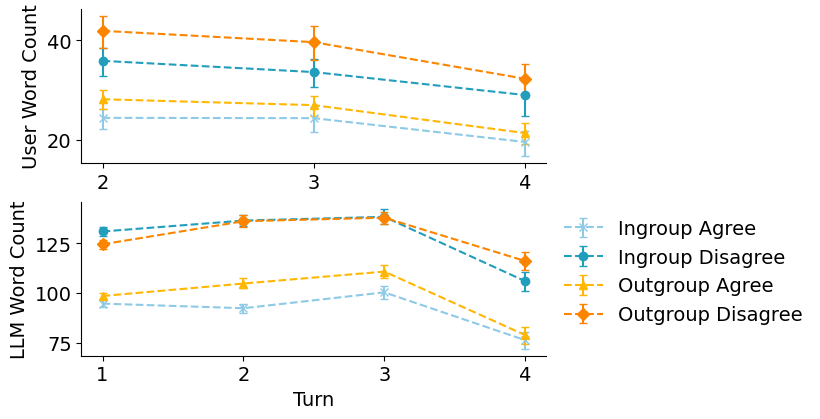

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(6, 4.5))
colors = ["#8ecae6", "#219ebc", "#ffb703", "#fb8500"]
markers = ["x", "o", "^", "D"]
for row, ax, ci, group in zip([0,1], axs, [user_ci, llm_ci], ["User", "LLM"]):
    for treatment, color, marker in zip(treatments, colors, markers):
        ci_treatment = ci[treatment]
        # vals = [*ci_treatment.values()]
        # x = [1,2,3,4,5]
        if row == 1:
            vals = [*ci_treatment.values()][:-1]
            x = [1,2,3,4]
        else:
            vals = [*ci_treatment.values()][1:-1]
            x = [2,3,4]
        y = np.array([v[1] for v in vals])
        yerr = np.array([[v[2]-v[1], v[1]-v[0]] for v in vals]).T  # Transpose to get shape (2, 5)

        ax.errorbar(x = x,
                    y = y,
                    yerr = yerr,
                    markersize=6, capsize=3, label=treatment, linestyle='--', color=color, marker=marker)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(x)
    ax.set_ylabel(f"{group} Word Count")

ax.legend(frameon=False,bbox_to_anchor=(1,1))
ax.set_xlabel("Turn")
plt.subplots_adjust(hspace=0.25)